<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("E://train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

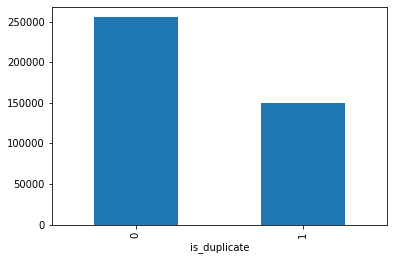

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



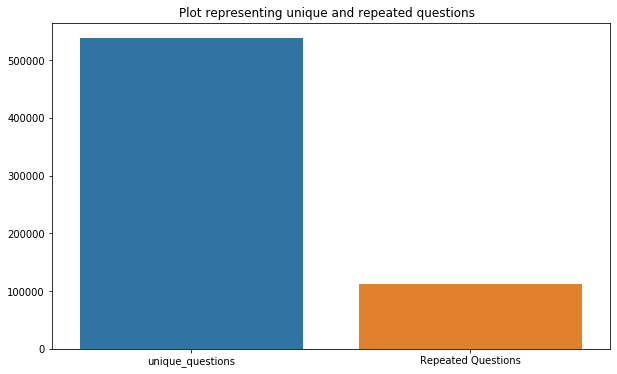

In [9]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



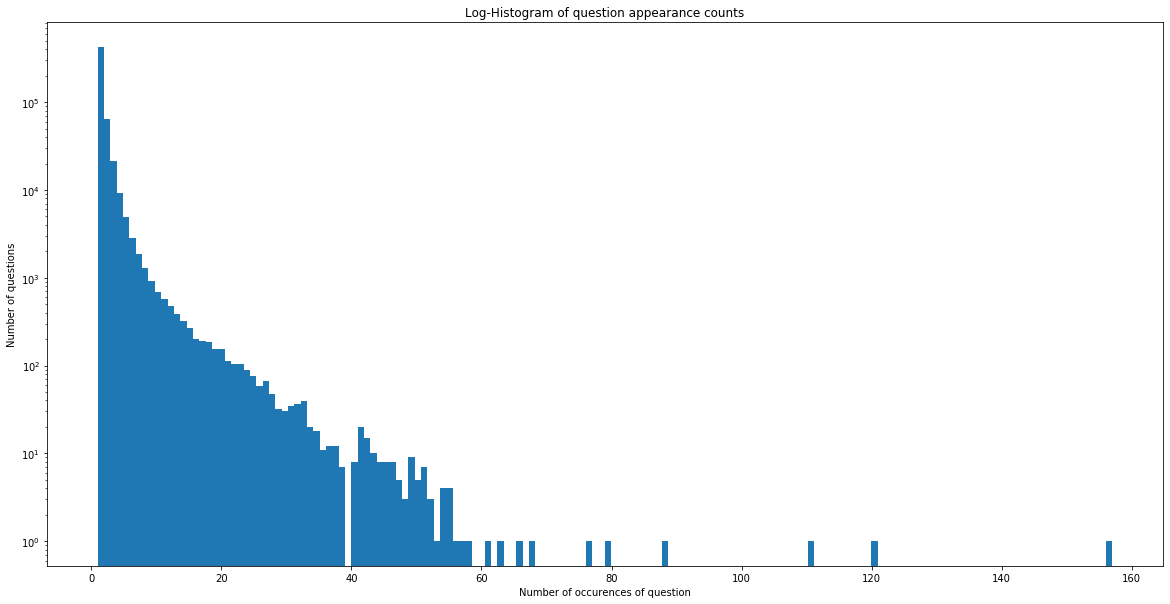

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [13]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [15]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

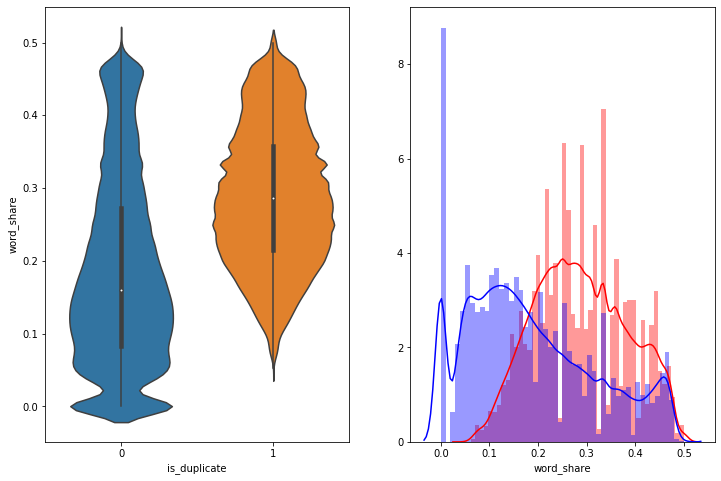

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

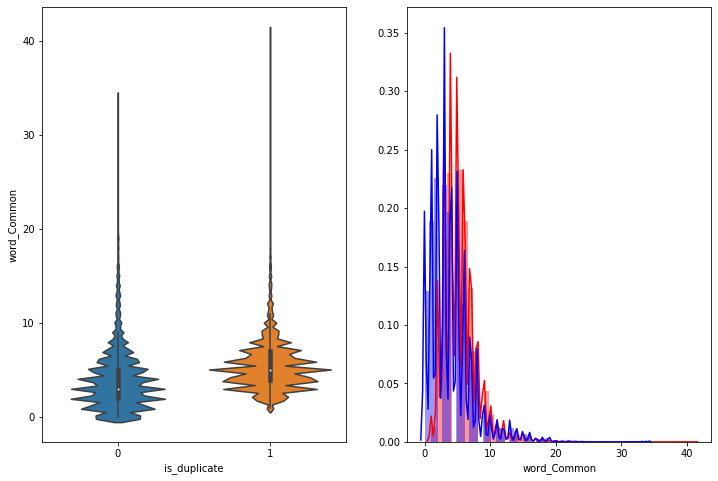

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

# Performing Exploratory Data Analysis

In [18]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [19]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [20]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

 <h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [21]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [22]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [23]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("E://train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [24]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [25]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'),encoding='utf-8').read()
textn_w = open(path.join(d, 'train_n.txt'),encoding='utf-8').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


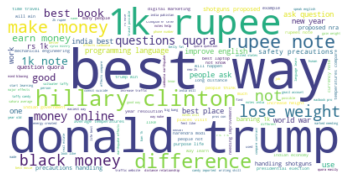

In [26]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


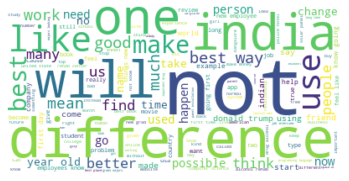

In [27]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

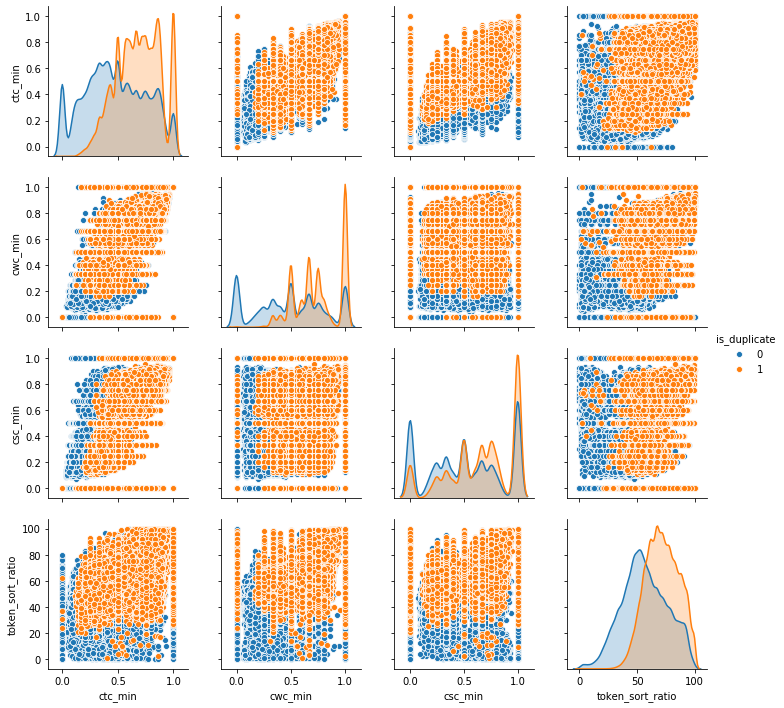

In [28]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

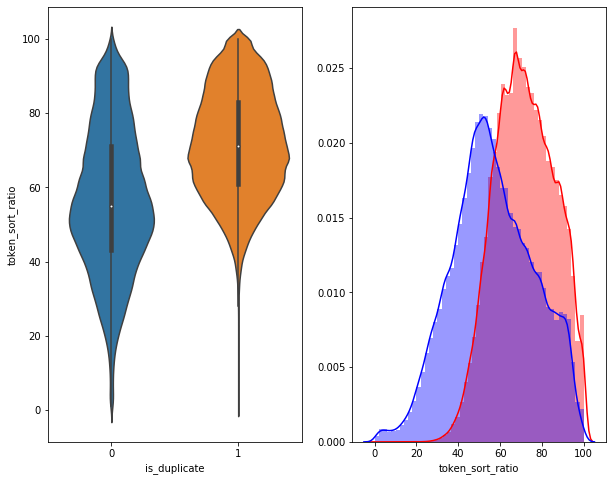

In [29]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

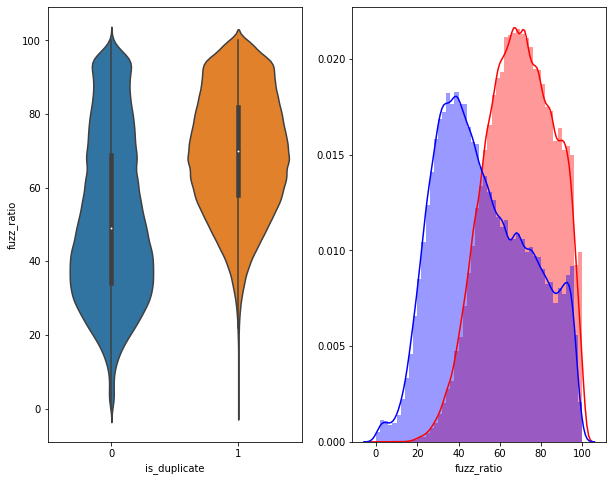

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [31]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [32]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.125s...
[t-SNE] Computed neighbors for 5000 samples in 0.602s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.416s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 3.895s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 2.460s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 2.469s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 2.507s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

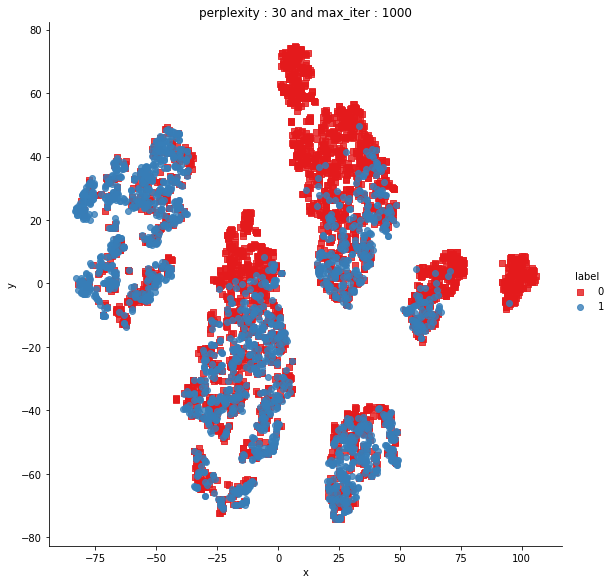

In [33]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [34]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.031s...
[t-SNE] Computed neighbors for 5000 samples in 0.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.263s
[t-SNE] Iteration 50: error = 80.5316772, gradient norm = 0.0296611 (50 iterations in 11.863s)
[t-SNE] Iteration 100: error = 69.3815765, gradient norm = 0.0033166 (50 iterations in 6.081s)
[t-SNE] Iteration 150: error = 67.9724655, gradient norm = 0.0018542 (50 iterations in 5.515s)
[t-SNE] Iteration 200: error = 67.4176865, gradient norm = 0.0012513 (50 iterations in 5.593s)
[t-SNE] Iteration 250: error = 67.1036377, gradient norm = 0.000909

In [35]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [32]:
# avoid decoding problems
df = pd.read_csv("E://train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [33]:
df.head(10)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   
8   8    17    18                    When do you use シ instead of し?   
9   9    19    20  Motorola (company): Can I hack my Charter Moto...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1  
6  What keeps childern active and far from phone ...             0  
7          What should I do to be a great geologist?             1  
8              When do you use "&" instead of "and"?             0  
9  How do I hack Motorola DCX3400 for free internet?             0

In [34]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [35]:
dfnlp.head(5)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   
2  how can internet speed be increased by hacking...             0  0.399992   
3  find the remainder when  math 23  24   math  i...             0  0.000000   
4            which fish would survive in salt water              0  0.399992   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   
2  0.333328  0.399992  0.249997  ...  0.285712           0.0            1.0   
3  0.000000  0.000000  0.000000  ...  0.000000           0.0            0.0   
4  0.199998  0.999950  0.666644  ...  0.307690           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   
2           4.0      12.0               63                63          43   
3           2.0      12.0               28                24           9   
4           6.0      10.0               67                47          35   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  
2                  47              0.166667  
3                  14              0.039216  
4                  56              0.175000  

[5 rows x 21 columns]

In [36]:
dfppro.head(5)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

In [37]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2=dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [38]:
df1  = dfnlp.merge(dfppro, on='id',how='left')

In [39]:
df1 = df1.drop(['qid1_x','qid2_x'],axis=1)

In [40]:
df4  = df1.merge(df3, on='id',how='left')

In [41]:
df4.shape

(404290, 35)

In [42]:
y_true=df4['is_duplicate_x']

In [43]:
y_true

0         0
1         0
2         0
3         0
4         0
         ..
404285    0
404286    1
404287    0
404288    0
404289    0
Name: is_duplicate_x, Length: 404290, dtype: int64

In [44]:
y_true.isnull().sum()

0

In [45]:
df4 = df4.drop(['is_duplicate_x'],axis=1)

In [46]:
df4.shape

(404290, 34)

In [47]:
df4.isnull().values.any()

True


# Splitting the Data 

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df4, y_true, stratify=y_true, test_size=0.3)

In [49]:
print("The shape of train",X_train.shape,y_train.shape)
print("The shape of test",X_test.shape,y_test.shape)

The shape of train (283003, 34) (283003,)
The shape of test (121287, 34) (121287,)


In [50]:
# Filling the null values with ' '
X_train = X_train.fillna(' ')
nan_rows1 = X_train[X_train.isnull().any(1)]
print (nan_rows1)

# Filling the null values with ' '
X_test = X_test.fillna(' ')
nan_rows2 = X_test[X_test.isnull().any(1)]
print (nan_rows2)

Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]
Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]


In [51]:
X_train.isnull().values.any()

False

In [52]:
X_test.isnull().values.any()

False

# Applying the TFIDFW2V Vectorizing

In [54]:
X_train['question1_x'].isnull().values.any()

False

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(X_train['question1_x']) + list(X_train['question2_x'])

tfidf_train = TfidfVectorizer(lowercase=False, )
tfidf_train.fit_transform(questions_train)

# # dict key:word and value:tf-idf score
word2tfidf_train = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [56]:
import spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1_x'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)

100%|██████████████████████████████████| 283003/283003 [54:33<00:00, 86.45it/s]


In [57]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2_x'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

100%|██████████████████████████████████| 283003/283003 [54:45<00:00, 86.14it/s]


In [58]:
X_train.shape

(283003, 36)

In [59]:
X_train.isnull().values.any()

False

In [60]:
X_train_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
X_train_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)

In [61]:
X_train.drop(['q1_feats_m','q2_feats_m'],axis=1)

id                                        question1_x  \
30730    30730     how can i make small holes in drinkware glass    
77251    77251  what is the interview process for the position...   
12616    12616  when should one use median  as opposed to aver...   
157890  157890  is stainless steel brittle or ductile at room ...   
214157  214157                               what is description    
...        ...                                                ...   
127170  127170  how do foreigners view china after visiting ch...   
202504  202504              what are the best books for robotics    
116202  116202                                      what is safe    
391033  391033      how accurate are nostradamus own predictions    
234272  234272  why are physicists incapable of understanding ...   

                                              question2_x   cwc_min   cwc_max  \
30730         how do i make a needle sized hole in glass   0.399992  0.399992   
77251   what is the interview process like for the tec...  0.999983  0.857131   
12616                   when should i use mean vs median   0.499988  0.399992   
157890  why are metals mostly ductile while ceramics a...  0.666656  0.571420   
214157                        what are descriptive lines   0.000000  0.000000   
...                                                   ...       ...       ...   
127170  what do americans think about michelle obama o...  0.249994  0.166664   
202504                     what is the best robotic book   0.333322  0.333322   
116202        what shall i do to be safe on the internet   0.999900  0.333322   
391033  who was nostradamus and what were his predicti...  0.999950  0.666644   
234272  is wave particle duality a moving particle and...  0.666659  0.545450   

         csc_min   csc_max   ctc_min   ctc_max  last_word_eq  ...  freq_qid2  \
30730   0.749981  0.599988  0.555549  0.499995           1.0  ...          1   
77251   0.999980  0.833319  0.846147  0.846147           1.0  ...          1   
12616   0.666644  0.499988  0.571420  0.444440           0.0  ...          1   
157890  0.333322  0.249994  0.555549  0.416663           1.0  ...          1   
214157  0.499975  0.499975  0.333322  0.249994           0.0  ...          1   
...          ...       ...       ...       ...           ...  ...        ...   
127170  0.333322  0.199996  0.249997  0.181817           1.0  ...          1   
202504  0.666644  0.499988  0.499992  0.428565           0.0  ...          2   
116202  0.499975  0.142855  0.666644  0.199998           0.0  ...          1   
391033  0.000000  0.000000  0.333328  0.249997           1.0  ...          1   
234272  0.999983  0.666659  0.705878  0.545452           1.0  ...          1   

        q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
30730      46     43           9           9          5.0        18.0   
77251      80     80          13          13          9.0        24.0   
12616      50     33           9           7          3.0        16.0   
157890     58     77           9          12          5.0        20.0   
214157     20     27           3           4          1.0         7.0   
...       ...    ...         ...         ...          ...         ...   
127170     50     62           8          10          2.0        18.0   
202504     37     30           7           6          3.0        13.0   
116202     13     43           3          10          1.0        13.0   
391033     43     50           5           8          1.0        13.0   
234272    146     99          21          16         13.0        37.0   

        word_share  freq_q1+q2  freq_q1-q2  
30730     0.277778           2           0  
77251     0.375000           2           0  
12616     0.187500           3           1  
157890    0.250000           2           0  
214157    0.142857           3           1  
...            ...         ...         ...  
127170    0.111111           3           1  
202504    0.

In [62]:
X_train_q1['id']=X_train['id']
X_train_q2['id']=X_train['id']
df1  = X_train_q1.merge(X_train_q2, on='id',how='left')
X_train  = X_train.merge(df1, on='id',how='left')

In [63]:
X_train.shape

(283003, 228)

In [64]:
X_train.isnull().values.any()

False

# TFIDF Vectorizing on Test Data

In [65]:
X_test['question1_x'].isnull().values.any()

False

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_test = list(X_test['question1_x']) + list(X_test['question2_x'])

# tfidf_train = TfidfVectorizer(lowercase=False, )
tfidf_train.transform(questions_test)

# # dict key:word and value:tf-idf score
word2tfidf_test = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))

In [67]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1_x'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)

100%|██████████████████████████████████| 121287/121287 [23:13<00:00, 87.01it/s]


In [69]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2_x'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

100%|██████████████████████████████████| 121287/121287 [25:03<00:00, 80.68it/s]


In [70]:
X_test_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
X_test_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

In [71]:
X_test.drop(['q1_feats_m','q2_feats_m'],axis=1)                                              

id                                        question1_x  \
320260  320260  why did the us have so many poor performing pr...   
138841  138841      how do you get rid of boredom and irritation    
83769    83769  what are some things new employees should know...   
178236  178236                      what is syria current status    
316110  316110    is there any evidence that quarks really exist    
...        ...                                                ...   
316106  316106  why was henry kissinger never tried for war cr...   
15267    15267  what is the nearest airport to daytona beach  ...   
34586    34586                what is epistemology in psychology    
25017    25017                  how do i get rid of my belly fat    
307903  307903                  how does the manglik dosha occur    

                                              question2_x   cwc_min   cwc_max  \
320260  how can i learn to speak like someone from the...  0.428565  0.374995   
138841     boredom is killing me  how do i get rid of it   0.749981  0.749981   
83769   what are some things new employees should know...  0.899991  0.899991   
178236  what is current status of russia in syria crisis   0.999967  0.599988   
316110                  how do we know that quarks exist   0.666644  0.499988   
...                                                   ...       ...       ...   
316106    should henry kissinger be tried for war crimes   0.999980  0.833319   
15267   what is the nearest airport to daytona beach  ...  0.888879  0.888879   
34586                               what is epistemology   0.999900  0.499975   
25017   what is the best way to reduce belly and arm fat   0.499988  0.333328   
307903                     why does manglik dosha occurs   0.666644  0.666644   

         csc_min   csc_max   ctc_min   ctc_max  last_word_eq  ...  freq_qid2  \
320260  0.166664  0.166664  0.307690  0.266665           1.0  ...          1   
138841  0.599988  0.428565  0.666659  0.545450           0.0  ...          4   
83769   0.999986  0.999986  0.941171  0.941171           1.0  ...          1   
178236  0.999950  0.499988  0.999980  0.555549           0.0  ...          1   
316110  0.249994  0.249994  0.428565  0.374995           1.0  ...          2   
...          ...       ...       ...       ...           ...  ...        ...   
316106  0.333322  0.333322  0.749991  0.666659           1.0  ...          1   
15267   0.999989  0.999989  0.894732  0.894732           1.0  ...          1   
34586   0.999950  0.666644  0.999967  0.599988           0.0  ...          2   
25017   0.000000  0.000000  0.222220  0.181817           1.0  ...          4   
307903  0.499975  0.333322  0.599988  0.499992           0.0  ...          1   

        q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
320260     79     64          15          13          4.0        27.0   
138841     45     46           9          11          6.0        20.0   
83769     100     97          17          17         16.0        34.0   
178236     29     49           5           9          4.0        14.0   
316110     47     33           8           7          3.0        15.0   
...       ...    ...         ...         ...          ...         ...   
316106     51     47           9           8          6.0        17.0   
15267     110    109          18          18         16.0        34.0   
34586      35     21           5           3          2.0         8.0   
25017      33     49           9          11          2.0        20.0   
307903     33     30           6           5          3.0        11.0   

        word_share  freq_q1+q2  freq_q1-q2  
320260    0.148148           2           0  
138841    0.300000           7           1  
83769     0.470588           2           0  
178236    0.285714           2           0  
316110    0.200000           3           1  
...            ...         ...         ...  
316106    0.352941           4           2  
15267     0.

In [72]:
X_test_q1['id']=X_test['id']
X_test_q2['id']=X_test['id']
df_test  = X_test_q1.merge(X_test_q2, on='id',how='left')
X_test  = X_test.merge(df_test, on='id',how='left')

In [73]:
X_test.shape

(121287, 228)

In [74]:
X_test.isnull().values.any()

False

# Storing the final features 

In [75]:
X_train.to_pickle("X_train.txt")
y_train.to_pickle("y_train.txt")
X_test.to_pickle("X_test.txt")
y_test.to_pickle("y_test.txt")

In [76]:
X_train = pd.read_pickle("X_train.txt")
y_train = pd.read_pickle("y_train.txt")
X_test = pd.read_pickle("X_test.txt")
y_test = pd.read_pickle("y_test.txt")

In [77]:
X_train = X_train.drop(['id','question1_x','question2_x','q1_feats_m','q2_feats_m','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],axis=1)
# X_train.drop(X_train.index[0], inplace=True)
X_test = X_test.drop(['id','question1_x','question2_x','q1_feats_m','q2_feats_m','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],axis=1)
# X_test.drop(X_test.index[0], inplace=True)

In [78]:
X_train

cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  \
0       0.399992  0.399992  0.749981  0.599988  0.555549  0.499995   
1       0.999983  0.857131  0.999980  0.833319  0.846147  0.846147   
2       0.499988  0.399992  0.666644  0.499988  0.571420  0.444440   
3       0.666656  0.571420  0.333322  0.249994  0.555549  0.416663   
4       0.000000  0.000000  0.499975  0.499975  0.333322  0.249994   
...          ...       ...       ...       ...       ...       ...   
282998  0.249994  0.166664  0.333322  0.199996  0.249997  0.181817   
282999  0.333322  0.333322  0.666644  0.499988  0.499992  0.428565   
283000  0.999900  0.333322  0.499975  0.142855  0.666644  0.199998   
283001  0.999950  0.666644  0.000000  0.000000  0.333328  0.249997   
283002  0.666659  0.545450  0.999983  0.666659  0.705878  0.545452   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  ...       86_y  \
0                1.0            1.0           1.0       9.5  ... -59.623962   
1                1.0            1.0           0.0      13.0  ... -77.593863   
2                0.0            1.0           2.0       8.0  ... -49.559126   
3                1.0            0.0           3.0      10.5  ...  37.961039   
4                0.0            1.0           1.0       3.5  ...  -8.918076   
...              ...            ...           ...       ...  ...        ...   
282998           1.0            0.0           3.0       9.5  ...  30.057918   
282999           0.0            1.0           1.0       6.5  ... -15.413639   
283000           0.0            1.0           7.0       6.5  ... -15.232469   
283001           1.0            0.0           2.0       7.0  ...  94.211827   
283002           1.0            0.0           5.0      19.5  ...  -2.583158   

             87_y       88_y       89_y       90_y        91_y        92_y  \
0      -17.244666  22.454798 -28.656576 -40.745821   -9.385758  -54.076120   
1        3.991977 -46.238965  93.702298  15.591976   45.755461   24.318352   
2      -31.962316   5.772173   8.008571   1.255951  -13.635255  -46.601089   
3      -83.609502 -70.694985  88.313514  24.140536 -100.485078   35.589062   
4      -15.794137   4.355531  55.801591 -32.215686  -30.300247   21.767027   
...           ...        ...        ...        ...         ...         ...   
282998 -60.711641 -31.059682  86.364238 -25.545382 -107.959108  -19.394951   
282999  20.059164  11.769451  -5.407591 -39.867506   -2.656209   16.894822   
283000 -17.997450  -8.746927  22.156518 -38.199581   -8.060257  -35.593737   
283001  20.770693 -53.397401  35.410210   7.357102  -28.506049  105.429732   
283002 -53.306752 -17.738335  64.942601  -3.051115  -25.883721   50.346755   

              93_y        94_y       95_y  
0        53.352814   24.582005  19.268519  
1        73.193066   81.721174  88.063593  
2        50.244447  -29.551442 -33.405613  
3         9.135094    8.647112  74.757333  
4         0.786610    0.001570  45.214701  
...            ...         ...        ...  
282998   89.969050  -25.438716  15.080043  
282999    7.059640  -22.651982  31.529629  
283000   70.947977  -46.836348  20.607995  
283001   60.623247   29.657900  81.707806  
283002  137.276209  148.851390  75.252679  

[283003 rows x 218 columns]

In [79]:
X_test

cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  \
0       0.428565  0.374995  0.166664  0.166664  0.307690  0.266665   
1       0.749981  0.749981  0.599988  0.428565  0.666659  0.545450   
2       0.899991  0.899991  0.999986  0.999986  0.941171  0.941171   
3       0.999967  0.599988  0.999950  0.499988  0.999980  0.555549   
4       0.666644  0.499988  0.249994  0.249994  0.428565  0.374995   
...          ...       ...       ...       ...       ...       ...   
121282  0.999980  0.833319  0.333322  0.333322  0.749991  0.666659   
121283  0.888879  0.888879  0.999989  0.999989  0.894732  0.894732   
121284  0.999900  0.499975  0.999950  0.666644  0.999967  0.599988   
121285  0.499988  0.333328  0.000000  0.000000  0.222220  0.181817   
121286  0.666644  0.666644  0.499975  0.333322  0.599988  0.499992   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  ...       86_y  \
0                1.0            0.0           2.0      14.0  ... -17.137174   
1                0.0            0.0           2.0      10.0  ...   4.629878   
2                1.0            1.0           0.0      17.0  ...  46.811908   
3                0.0            1.0           4.0       7.0  ... -23.099375   
4                1.0            0.0           1.0       7.5  ...  51.943918   
...              ...            ...           ...       ...  ...        ...   
121282           1.0            0.0           1.0       8.5  ... -40.075282   
121283           1.0            1.0           0.0      19.0  ... -55.956094   
121284           0.0            1.0           2.0       4.0  ...   8.234739   
121285           1.0            0.0           2.0      10.0  ... -40.216468   
121286           0.0            0.0           1.0       5.5  ... -20.956846   

             87_y        88_y       89_y       90_y       91_y        92_y  \
0      -12.527744   -5.953752  47.614672  -6.756071  -0.971495  -53.919867   
1        1.401683  -25.555265   3.432252 -34.759387 -50.818879    2.948030   
2      -28.765955 -111.090772 -58.664812 -87.426555 -64.700349   52.992889   
3      -46.617072   13.460113  46.617194  -2.763695 -66.164694   14.814696   
4       -4.997771  -22.874212 -16.311581 -36.096955 -25.686830    9.683561   
...           ...         ...        ...        ...        ...         ...   
121282 -72.946865    2.991685  23.187379 -36.920694 -74.285424   12.511110   
121283  36.293648 -116.637615  60.430289   9.955740  57.735041  174.760852   
121284  30.382448  -49.320768  -2.199446 -45.298561  24.266693    3.175277   
121285  47.309624  -23.613600  32.780483   2.000290   3.131105  -82.556180   
121286 -46.580226  -30.712147 -32.176333 -33.042156  12.250231   -1.043592   

              93_y       94_y        95_y  
0        71.846773 -18.499593   57.430948  
1        37.797070  14.779398   63.972872  
2        89.258161  13.899387  109.915318  
3       133.809839  43.180377  -18.948357  
4         7.139447 -66.004672   22.176997  
...            ...        ...         ...  
121282   -4.018852 -18.175551   39.309192  
121283   93.736115 -13.760311  141.899570  
121284   35.621008  12.610075  -10.905840  
121285   28.599582  67.128847   -2.535801  
121286   18.069797 -17.304264    9.365012  

[121287 rows x 218 columns]

In [80]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_train.columns)
for i in cols:
    X_train[i] = X_train[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [81]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_test.columns)
for i in cols:
    X_test[i] = X_test[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [82]:
X_train.isnull().values.any()

False

In [83]:
X_test.isnull().values.any()

False

# Applying Models

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [85]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 218)
Number of data points in test data : (121287, 218)


In [86]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [87]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building a Random Model and setting it as a benchmark

Log loss on Test Data using Random Model 0.8877955772426186


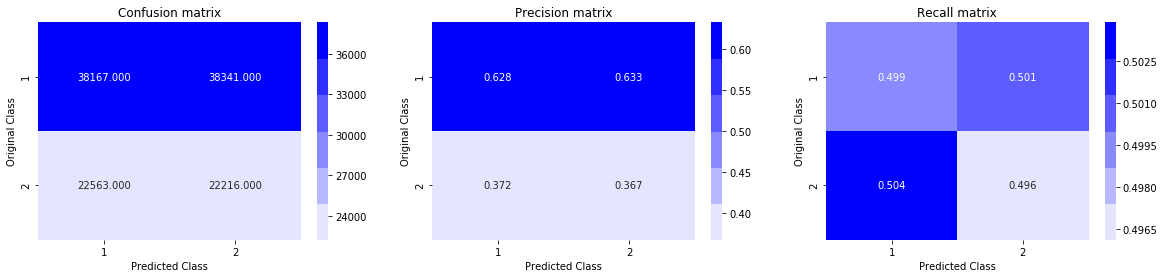

In [88]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with hyperparameter

For values of alpha =  1e-05 The log loss is: 0.44733161135794197
For values of alpha =  0.0001 The log loss is: 0.44958712837358666
For values of alpha =  0.001 The log loss is: 0.44582889599437403
For values of alpha =  0.01 The log loss is: 0.43038998392260697
For values of alpha =  0.1 The log loss is: 0.45351647838726844
For values of alpha =  1 The log loss is: 0.4854754136984772
For values of alpha =  10 The log loss is: 0.5220744579762643


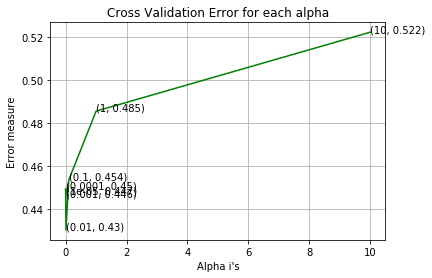

For values of best alpha =  0.01 The train log loss is: 0.42992453632611655
For values of best alpha =  0.01 The test log loss is: 0.43038998392260697
Total number of data points : 121287


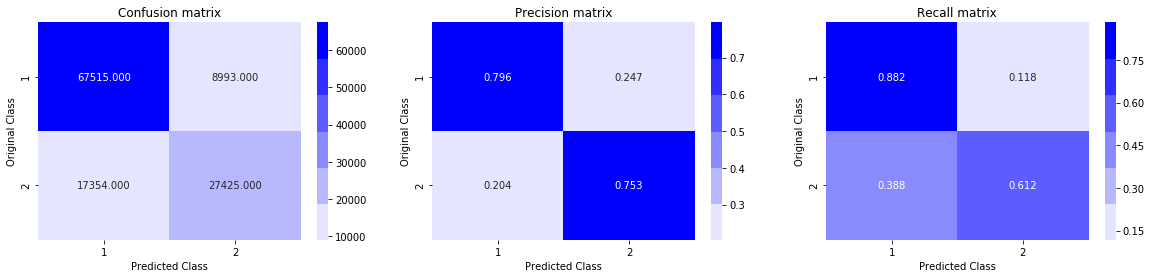

In [89]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM  on TFIDFW2V Vectoring Technique

For values of alpha =  1e-05 The log loss is: 0.5622172639789572
For values of alpha =  0.0001 The log loss is: 0.6585278256347588
For values of alpha =  0.001 The log loss is: 0.5159823958048365
For values of alpha =  0.01 The log loss is: 0.4968349584978422
For values of alpha =  0.1 The log loss is: 0.5858726928166208
For values of alpha =  1 The log loss is: 0.6330152958210977
For values of alpha =  10 The log loss is: 0.6369234719023029


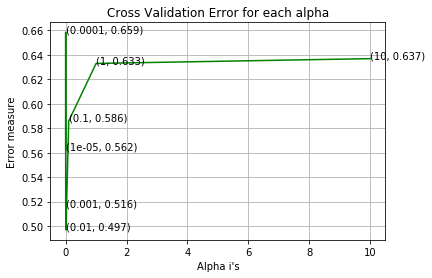

For values of best alpha =  0.01 The train log loss is: 0.4957373693023015
For values of best alpha =  0.01 The test log loss is: 0.4968349584978422
Total number of data points : 121287


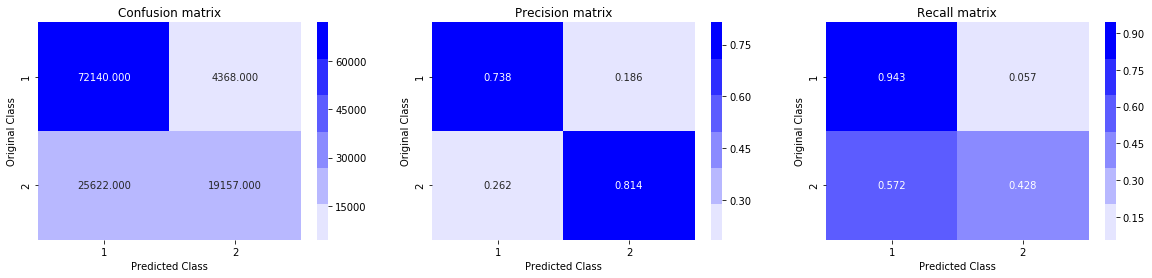

In [90]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBOOST Hyperparameter Tunning 

## XGBOOST hyperparameter on TFIDFW2V Vectoring Technique

## Applying XGBOOST using RandomSearch

In [92]:
#Refer :https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
#Refer:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lxgb
params = {      
    'max_depth': [3, 4, 5, 6, 7, 8],       
    'eta' : [0.01, 0.02, 0.05, 0.1]    
}

lightxgb = lxgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')
random_search = RandomizedSearchCV(lightxgb, param_distributions=params, scoring='neg_log_loss',return_train_score=True,cv=3) 
final_random=random_search.fit(X_train, y_train)

print("best parameters from randomsearch :",final_random.best_params_)

print("best score from randomsearch :",final_random.best_score_)


best parameters from randomsearch : {'max_depth': 8, 'eta': 0.1}
best score from randomsearch : -0.3502110654991842


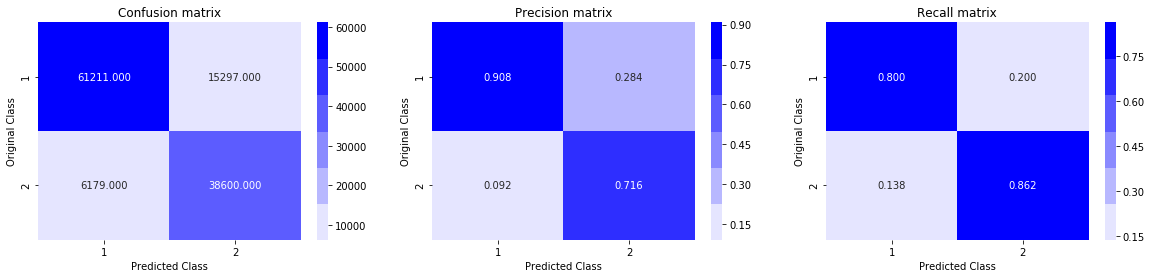

In [99]:
# applying xgboost using optimal parameters
optimal_xgb = lxgb.LGBMClassifier(boosting_type='gbdt',ets=0.1, max_depth= 8, class_weight='balanced')

optimal_xgb.fit(X_train,y_train)
predicted_y= optimal_xgb.predict(X_test)
plot_confusion_matrix(y_test,predicted_y)

## Applying the TFIDF Vectorizing Technique with Logistic Regression and Linear SVM

In [164]:
df4  = df1.merge(df3, on='id',how='left')

In [165]:
df4.shape

(404290, 35)

In [166]:
y_true=df4['is_duplicate_x']

In [167]:
df4 = df4.drop(['is_duplicate_x'],axis=1)

In [168]:
df4.shape

(404290, 34)

In [169]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df4, y_true, stratify=y_true, test_size=0.3)

In [170]:
# Filling the null values with ' '
X_train = X_train.fillna(' ')
nan_rows1 = X_train[X_train.isnull().any(1)]
print (nan_rows1)

# Filling the null values with ' '
X_test = X_test.fillna(' ')
nan_rows2 = X_test[X_test.isnull().any(1)]
print (nan_rows2)

Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]
Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]


In [171]:
X_train.isnull().values.any()

False

In [172]:
X_test.isnull().values.any()

False

In [173]:
X_train.shape

(283003, 34)

In [174]:
X_test.shape

(121287, 34)

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [176]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# merge texts
questions = list(X_train['question1_x']) + list(X_train['question2_x'])
#questions = list(df['question1']) + list(df['question2'])

vectorizer.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [177]:
tfidf_train_ques1= vectorizer.transform(X_train['question1_x'])
print("Shape of matrix after one hot encodig ",tfidf_train_ques1.shape)

Shape of matrix after one hot encodig  (283003, 77731)


In [178]:
tfidf_train_ques2= vectorizer.transform(X_train['question2_x'])
print("Shape of matrix after one hot encodig ",tfidf_train_ques2.shape)

Shape of matrix after one hot encodig  (283003, 77731)


In [179]:
X_train_features=X_train.drop(['id','question1_x','question2_x','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],
                        axis=1)

In [180]:
X_train_features.shape

(283003, 26)

In [182]:
import scipy
print("train Shape Before -> ",X_train_features.shape," Type",type(X_train_features))

#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
train_sparse_matrix = scipy.sparse.csr_matrix(X_train_features)

print("train Shape After-> ",train_sparse_matrix.shape," Type",type(train_sparse_matrix))

train Shape Before ->  (283003, 26)  Type <class 'pandas.core.frame.DataFrame'>
train Shape After->  (283003, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>


In [183]:
tfidf_test_ques1= vectorizer.transform(X_test['question1_x'])
print("Shape of matrix after one hot encodig ",tfidf_test_ques1.shape)

Shape of matrix after one hot encodig  (121287, 77731)


In [184]:
tfidf_test_ques2= vectorizer.transform(X_test['question2_x'])
print("Shape of matrix after one hot encodig ",tfidf_test_ques2.shape)

Shape of matrix after one hot encodig  (121287, 77731)


In [185]:
X_test = X_test.drop(['id','question1_x','question2_x','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],
                     axis=1)

In [186]:
X_test.shape

(121287, 26)

In [187]:
print("train Shape Before -> ",X_test.shape," Type",type(X_test))

#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
test_sparse_matrix = scipy.sparse.csr_matrix(X_test)

print("train Shape After-> ",test_sparse_matrix.shape," Type",type(test_sparse_matrix))

train Shape Before ->  (121287, 26)  Type <class 'pandas.core.frame.DataFrame'>
train Shape After->  (121287, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>


In [188]:
# combining our tfidf and features into one 

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack


tfidf_train = hstack((tfidf_train_ques1,tfidf_train_ques2))
tfidf_test = hstack((tfidf_test_ques1,tfidf_test_ques2))

#final train and test data shape 
print("train data shape",tfidf_train.shape)

print("Test data shape ",tfidf_test.shape)

train data shape (283003, 155462)
Test data shape  (121287, 155462)


In [190]:
from scipy.sparse import hstack

tfidf_train = hstack((train_sparse_matrix,tfidf_train_ques1,tfidf_train_ques2))
tfidf_test = hstack((test_sparse_matrix,tfidf_test_ques1,tfidf_test_ques2))

#final train and test data shape 
print("train data shape",tfidf_train.shape)
print("Test data shape ",tfidf_test.shape)

train data shape (283003, 155488)
Test data shape  (121287, 155488)


# Confusion Matrix

In [191]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.3870861553269395
For values of alpha =  0.0001 The log loss is: 0.3850170249176714
For values of alpha =  0.001 The log loss is: 0.41763478713255986
For values of alpha =  0.01 The log loss is: 0.44444574932911174
For values of alpha =  0.1 The log loss is: 0.4619725789259233
For values of alpha =  1 The log loss is: 0.49277331456999457
For values of alpha =  10 The log loss is: 0.541353616007648


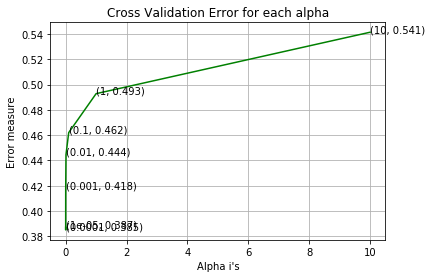

For values of best alpha =  0.0001 The train log loss is: 0.38298898123905095
For values of best alpha =  0.0001 The test log loss is: 0.3850170249176714
Total number of data points : 121287


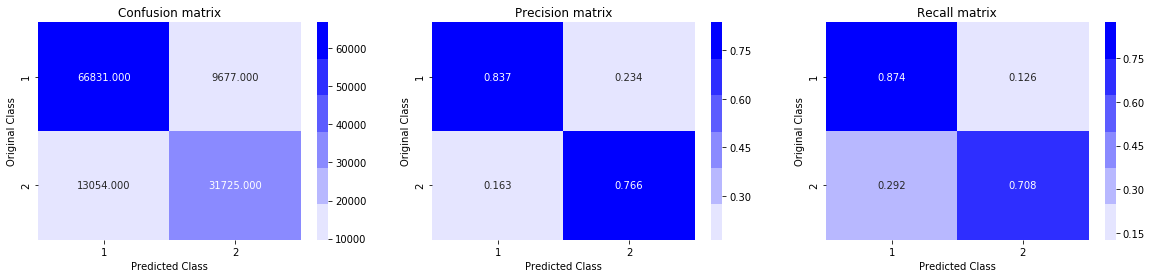

In [193]:

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4228320383008884
For values of alpha =  0.0001 The log loss is: 0.4489506087668175
For values of alpha =  0.001 The log loss is: 0.46474540143411774
For values of alpha =  0.01 The log loss is: 0.4741833160623336
For values of alpha =  0.1 The log loss is: 0.48271156569190665
For values of alpha =  1 The log loss is: 0.5773742723080194
For values of alpha =  10 The log loss is: 0.6140048885789179


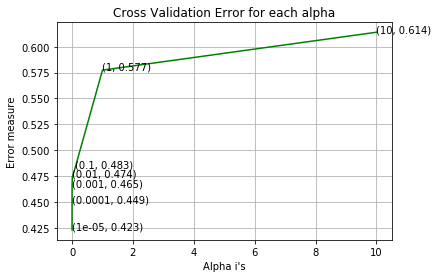

For values of best alpha =  1e-05 The train log loss is: 0.4211048480721476
For values of best alpha =  1e-05 The test log loss is: 0.4228320383008884
Total number of data points : 121287


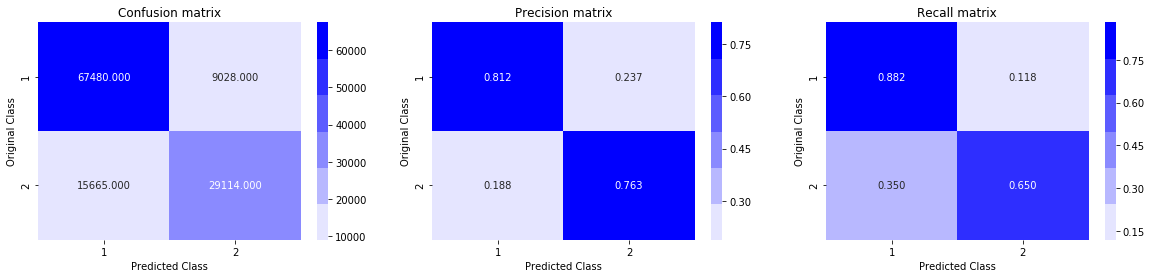

In [194]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

In [100]:
#Refer :https://ptable.readthedocs.io/en/latest/tutorial.html
from prettytable import PrettyTable

x = PrettyTable()

x.field_names =['No .', 'Featurization Technique', 'Model ( ML algorithm)','Hyper Parameter', 'Train log-loss', 'Test log-loss']

x.add_row([1, 'TF-IDF', 'Logistic Regression', 'alpha=0.0001',0.382, 0.385])
x.add_row([2, 'TF-IDF', 'Linear SVM', 'alpha=1e-05', 0.4211,0.4228])

y = PrettyTable()

y.field_names = ['No .', 'Featurization Technique', 'Model ( ML algorithm)','Depth','eta','log-loss']

y.add_row([1, 'TF-IDF weighted word2vec', 'LightXgboost', 8,0.1, 0.35])

print("Prettytbale is shown below:")
print(x)
print()
print(y)

Prettytbale is shown below:
+------+-------------------------+-----------------------+-----------------+----------------+---------------+
| No . | Featurization Technique | Model ( ML algorithm) | Hyper Parameter | Train log-loss | Test log-loss |
+------+-------------------------+-----------------------+-----------------+----------------+---------------+
|  1   |          TF-IDF         |  Logistic Regression  |   alpha=0.0001  |     0.382      |     0.385     |
|  2   |          TF-IDF         |       Linear SVM      |   alpha=1e-05   |     0.4211     |     0.4228    |
+------+-------------------------+-----------------------+-----------------+----------------+---------------+

+------+--------------------------+-----------------------+-------+-----+----------+
| No . | Featurization Technique  | Model ( ML algorithm) | Depth | eta | log-loss |
+------+--------------------------+-----------------------+-------+-----+----------+
|  1   | TF-IDF weighted word2vec |      LightXgboost   

# Documentation

The above case study is for classifying whether the question asked is similar or not.

1) Loading the data and preprocessing it

* Firstly we will loaad the data into a datafraame where in we can manipulate the data. 
* We will be perforing preprocesing on the data as it is a text data.Here preprocessing will be cleaning the data.
* Here we are having thre files train.csv, a preprocessing file and a nlp features file. We will merge all these files.

2) Performing Univariate Analysis

* Univariaate analysis is performed to get more indepth understanding of the dataset. Here we will under that the data is imbalanced.
* Are there any duplicate values present.

3) Using the fuzzywuzzy library feature engineering is being perfomed 

4) The we will be splitting the dataset and then applying TFDIF Weighted W2V vectorizing technique. We will do it after splitting so that there will be no data leakage problem.

5) Then on these vectorized data we will be applying three models 
* Logistic Regression

* Linear SVM

* LightXGBoost

6) Again on this data we will be applying TFIDF Vectorizing technique aand apply Logistic Regression and Linear SVM.


